In [52]:
from utils import *

In [53]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)
        
        return out

In [96]:
model = LSTMModel(78, 512, 5, 1).to(device=DEVICE).eval()
model.load_state_dict(
    torch.load("./models/testo.pth")
);

In [55]:
def Reward(outputs, price):
    reward = outputs * price
    return reward

In [56]:
data_X = torch.split(
    torch.load("data/X_test_lstm_decade_price_01_09.pt")
    .permute(0, 1, 3, 2)
    .to(torch.float32),
    1,
)
data_x = torch.split(
    torch.load("data/x_test_lstm_decade_price_01_09.pt").to(torch.float32), 1
)

In [57]:
qids = [9860, 9673, 9855, 9333]

In [58]:
price_mean, price_std = (21.134345428346453, 11.95153035815692)

In [63]:
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in enumerate(zip(data_X, data_x)):
    for j, price in enumerate(np.linspace(0, 500, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        
        mean_b = model(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward

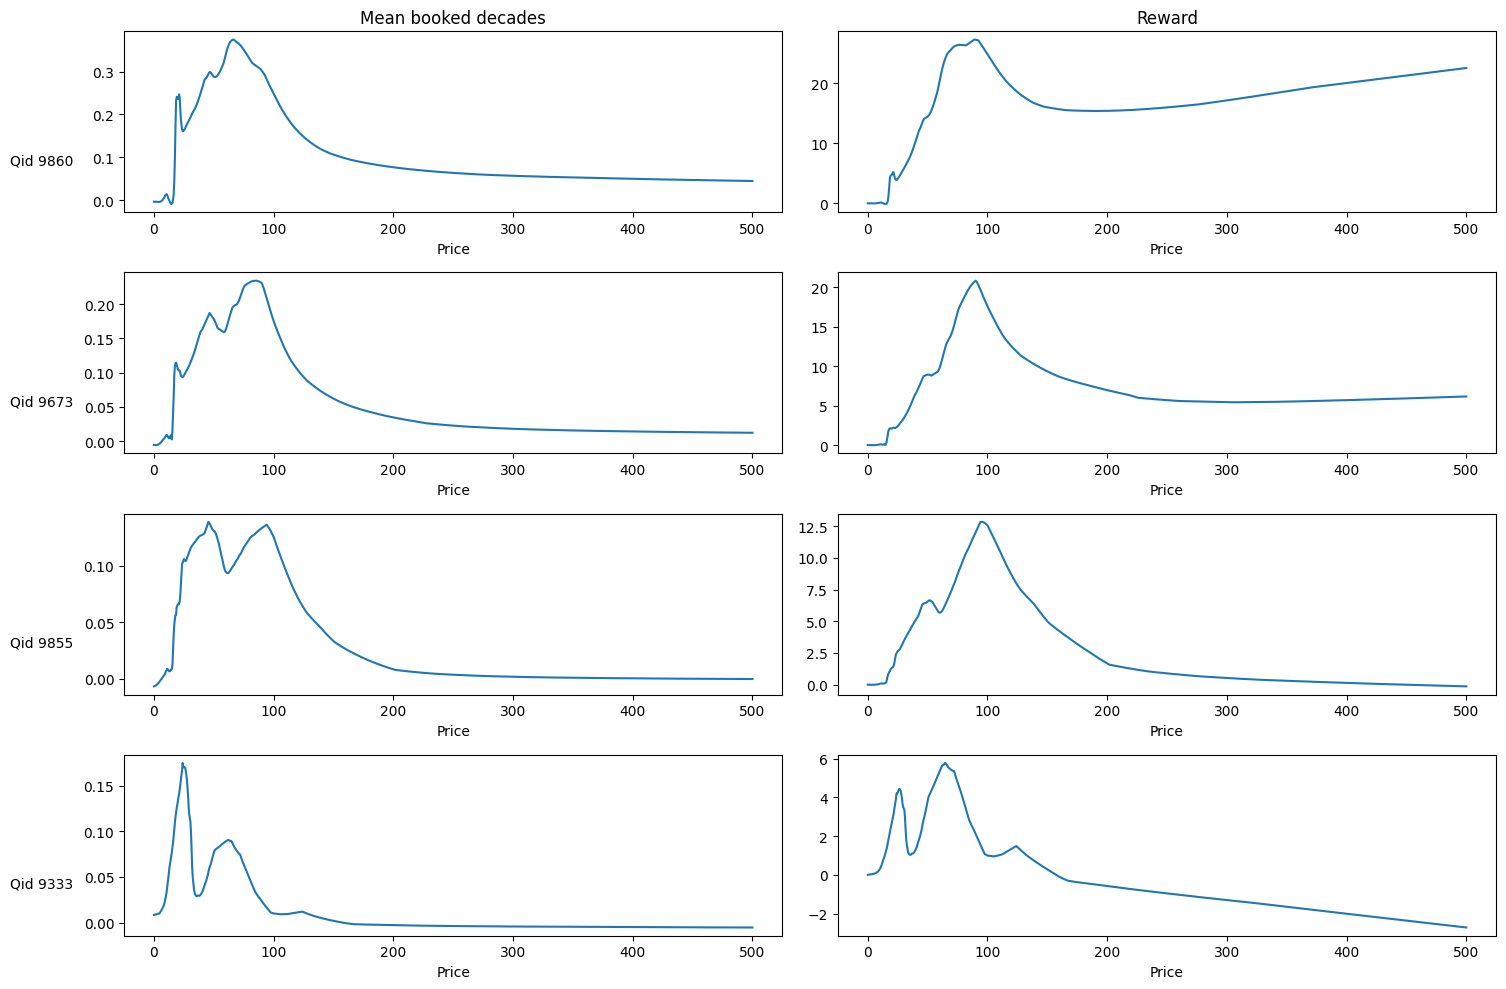

In [64]:
fig, ax = plt.subplots(M, 2, figsize=(15, 10))

for i in range(M):
    ax[i, 0].plot(history[i, 0, :], history[i, 1, :])
    ax[i, 1].plot(history[i, 0, :], history[i, 2, :])

for ax_, col in zip(ax[0], ["Mean booked decades", "Reward"]):
    ax_.set_title(col)

for i in range(M):
    ylabel = ax[i, 0].set_ylabel(f"Qid {qids[i]}")
    ax[i, 0].yaxis.set_label_coords(-1/8, 1/4)

    ylabel.set_rotation(0)

    ax[i, 0].set_xlabel(f"Price")
    ax[i, 1].set_xlabel(f"Price")

plt.tight_layout()

In [65]:
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in enumerate(zip(data_X, data_x)):
    for j, price in enumerate(np.linspace(0, 50, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        
        mean_b = model(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward

In [66]:
lbl = np.round(np.linspace(0, 50, 25), 0)

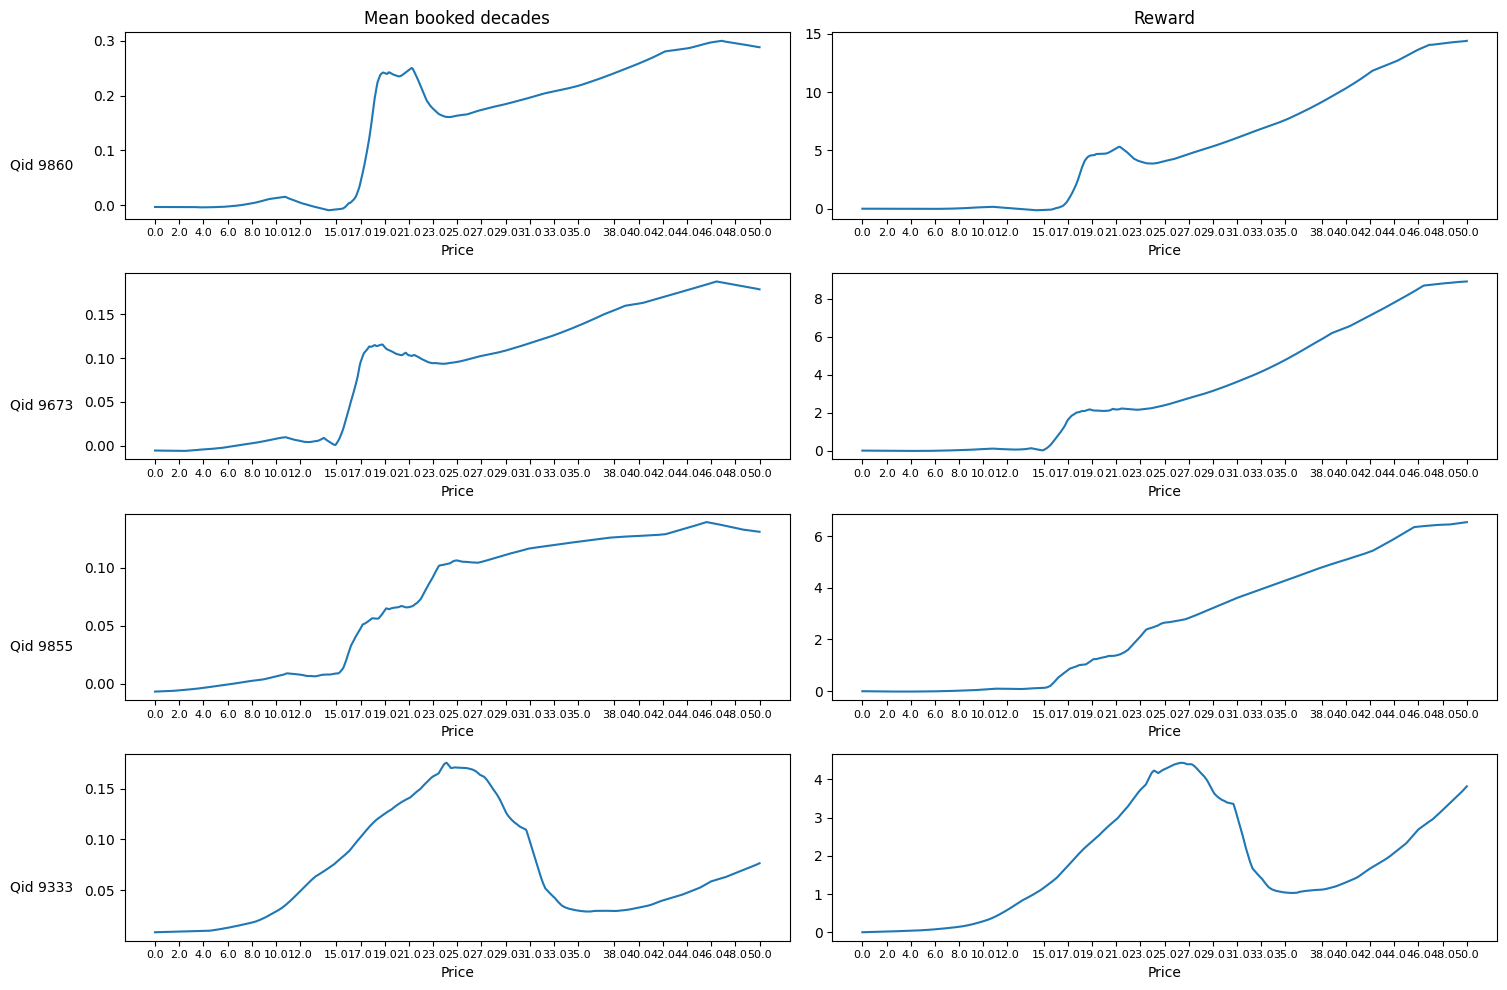

In [67]:
fig, ax = plt.subplots(M, 2, figsize=(15, 10))
from matplotlib.ticker import MaxNLocator

for i in range(M):
    ax[i, 0].plot(history[i, 0, :], history[i, 1, :])
    ax[i, 1].plot(history[i, 0, :], history[i, 2, :])

for ax_, col in zip(ax[0], ["Mean booked decades", "Reward"]):
    ax_.set_title(col)

for i in range(M):
    ylabel = ax[i, 0].set_ylabel(f"Qid {qids[i]}")
    ax[i, 0].yaxis.set_label_coords(-1/8, 1/4)
    ylabel.set_rotation(0)

    ax[i, 0].set_xlabel(f"Price")
    ax[i, 1].set_xlabel(f"Price")

    ax[i, 0].set_xticks(lbl)
    ax[i, 0].set_xticklabels(lbl)
    ax[i, 1].set_xticks(lbl)
    ax[i, 1].set_xticklabels(lbl)

    ax[i, 0].tick_params(axis="x", labelsize=8)
    ax[i, 1].tick_params(axis="x", labelsize=8)


plt.tight_layout()

In [ ]:
distance_2018 = pd.read_csv(
    "./data/distances/distances_2018_decade_price_data.csv"
).set_index("Qid1")
distance_2019 = pd.read_csv(
    "./data/distances/distances_2019_decade_price_data.csv"
).set_index("Qid1")
distance_2020 = pd.read_csv(
    "./data/distances/distances_2020_decade_price_data.csv"
).set_index("Qid1")
distance_2021 = pd.read_csv(
    "./data/distances/distances_2021_decade_price_data.csv"
).set_index("Qid1")
distance_2022 = pd.read_csv(
    "./data/distances/distances_2022_decade_price_data.csv"
).set_index("Qid1")
distance_2023 = pd.read_csv(
    "./data/distances/distances_2023_decade_price_data.csv"
).set_index("Qid1")

In [82]:
data = pd.read_pickle("./data/decade_price_data_combined.pkl")

In [83]:
qids = np.array([9860, 9673, 9855, 9333])

In [84]:
tmp = data[data.Qid.isin(qids)][["Qid", "Preis", "GJ"]]

In [85]:
tmp = tmp[tmp["GJ"] == 2023]

In [86]:
tmp.drop(columns="GJ", inplace=True)

In [89]:
tmp["Optimal Preis"] = [26, 18, 18, 21]

In [90]:
tmp

,Qid,Preis,Optimal Preis
319574,9333,28.6,26
320158,9673,18.1,18
320616,9855,18.0,18
320638,9860,18.8,21


In [91]:
tmp.loc[9860, "Neighbours 2018"] = (
    distance_2018[distance_2018.index == 9860].shape[0] - 1
)
tmp.loc[9860, "Neighbours 2019"] = (
    distance_2019[distance_2019.index == 9860].shape[0] - 1
)
tmp.loc[9860, "Neighbours 2020"] = (
    distance_2020[distance_2020.index == 9860].shape[0] - 1
)
tmp.loc[9860, "Neighbours 2021"] = (
    distance_2021[distance_2021.index == 9860].shape[0] - 1
)
tmp.loc[9860, "Neighbours 2022"] = (
    distance_2022[distance_2022.index == 9860].shape[0] - 1
)
tmp.loc[9860, "Neighbours 2023"] = (
    distance_2023[distance_2023.index == 9860].shape[0] - 1
)

tmp.loc[9673, "Neighbours 2018"] = (
    distance_2018[distance_2018.index == 9673].shape[0] - 1
)
tmp.loc[9673, "Neighbours 2019"] = (
    distance_2019[distance_2019.index == 9673].shape[0] - 1
)
tmp.loc[9673, "Neighbours 2020"] = (
    distance_2020[distance_2020.index == 9673].shape[0] - 1
)
tmp.loc[9673, "Neighbours 2021"] = (
    distance_2021[distance_2021.index == 9673].shape[0] - 1
)
tmp.loc[9673, "Neighbours 2022"] = (
    distance_2022[distance_2022.index == 9673].shape[0] - 1
)
tmp.loc[9673, "Neighbours 2023"] = (
    distance_2023[distance_2023.index == 9673].shape[0] - 1
)

tmp.loc[9855, "Neighbours 2018"] = (
    distance_2018[distance_2018.index == 9855].shape[0] - 1
)
tmp.loc[9855, "Neighbours 2019"] = (
    distance_2019[distance_2019.index == 9855].shape[0] - 1
)
tmp.loc[9855, "Neighbours 2020"] = (
    distance_2020[distance_2020.index == 9855].shape[0] - 1
)
tmp.loc[9855, "Neighbours 2021"] = (
    distance_2021[distance_2021.index == 9855].shape[0] - 1
)
tmp.loc[9855, "Neighbours 2022"] = (
    distance_2022[distance_2022.index == 9855].shape[0] - 1
)
tmp.loc[9855, "Neighbours 2023"] = (
    distance_2023[distance_2023.index == 9855].shape[0] - 1
)

tmp.loc[9333, "Neighbours 2018"] = (
    distance_2018[distance_2018.index == 9333].shape[0] - 1
)
tmp.loc[9333, "Neighbours 2019"] = (
    distance_2019[distance_2019.index == 9333].shape[0] - 1
)
tmp.loc[9333, "Neighbours 2020"] = (
    distance_2020[distance_2020.index == 9333].shape[0] - 1
)
tmp.loc[9333, "Neighbours 2021"] = (
    distance_2021[distance_2021.index == 9333].shape[0] - 1
)
tmp.loc[9333, "Neighbours 2022"] = (
    distance_2022[distance_2022.index == 9333].shape[0] - 1
)
tmp.loc[9333, "Neighbours 2023"] = (
    distance_2023[distance_2023.index == 9333].shape[0] - 1
)